# Import Library

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

# Load gambar

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("serat_kayu\\"):
    sub_folder_files = os.listdir(os.path.join("serat_kayu\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("serat_kayu\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


# Preprocessing percobaan 3

In [3]:
def resize(image, target_size):
    target_h, target_w = target_size
    src_h, src_w = image.shape
    resized = np.zeros((target_h, target_w), dtype=np.uint8)

    for i in range(target_h):
        for j in range(target_w):
            src_x = int(i * src_h / target_h)
            src_y = int(j * src_w / target_w)
            resized[i, j] = image[src_x, src_y]

    return resized


def konversi_grayscale(image):
    if len(image.shape) == 3:
        r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
        gray = 0.299 * r + 0.587 * g + 0.114 * b
        return gray.astype(np.uint8)
    else:
        return image 


def equalization(image):
    histogram = np.zeros(256, dtype=int)
    h, w = image.shape

    for i in range(h):
        for j in range(w):
            histogram[image[i, j]] += 1

    cdf = np.cumsum(histogram)
    cdf_min = np.min(cdf[np.nonzero(cdf)])
    total_pixels = h * w
    equalized = np.round((cdf[image] - cdf_min) / (total_pixels - cdf_min) * 255)
    equalized = np.clip(equalized, 0, 255).astype(np.uint8)

    return equalized


def edge_detection(image):
    kernel_x = np.array([[-1, 0, 1],
                         [-1, 0, 1],
                         [-1, 0, 1]])
    kernel_y = np.array([[1, 1, 1],
                         [0, 0, 0],
                         [-1, -1, -1]])

    h, w = image.shape
    result = np.zeros_like(image)
    padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            gx = np.sum(region * kernel_x)
            gy = np.sum(region * kernel_y)
            result[i, j] = np.clip(np.sqrt(gx**2 + gy**2), 0, 255)

    return result.astype(np.uint8)


def dilasi(image):
    kernel = np.ones((3, 3), dtype=np.uint8)
    h, w = image.shape
    output = np.zeros_like(image)
    padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            output[i, j] = np.max(region * kernel)

    return output


def erosi(image):
    kernel = np.ones((3, 3), dtype=np.uint8)
    h, w = image.shape
    output = np.zeros_like(image)
    padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(h):
        for j in range(w):
            region = padded[i:i+3, j:j+3]
            output[i, j] = np.min(region * kernel)

    return output

def gradient_morph(image):
   dilated = dilasi(image)
   eroded = erosi(image)
   gradient = cv.subtract(dilated, eroded)
   return gradient

def reduce_noise(image, kernel_size=3):
    return cv.medianBlur(image, kernel_size)

In [ ]:
dataPreprocessed = []

for i in range(len(data)):
    img = data[i] # ambil data hasil augmentasi

    # 1. Resize
    img = resize(img, (256,256))

    # 2. Konversi ke grayscale
    img = konversi_grayscale(img)

    # 3. Histogram Equalization untuk meningkatkan kontras
    img = equalization(img)

    # 4. Noise reduction
    img = reduce_noise(img)

    # 5. Erosi
    img = erosi(img)

    # 6. Dilasi
    img = dilasi(img)

    # Simpan hasil akhir preprocessing
    dataPreprocessed.append(img)


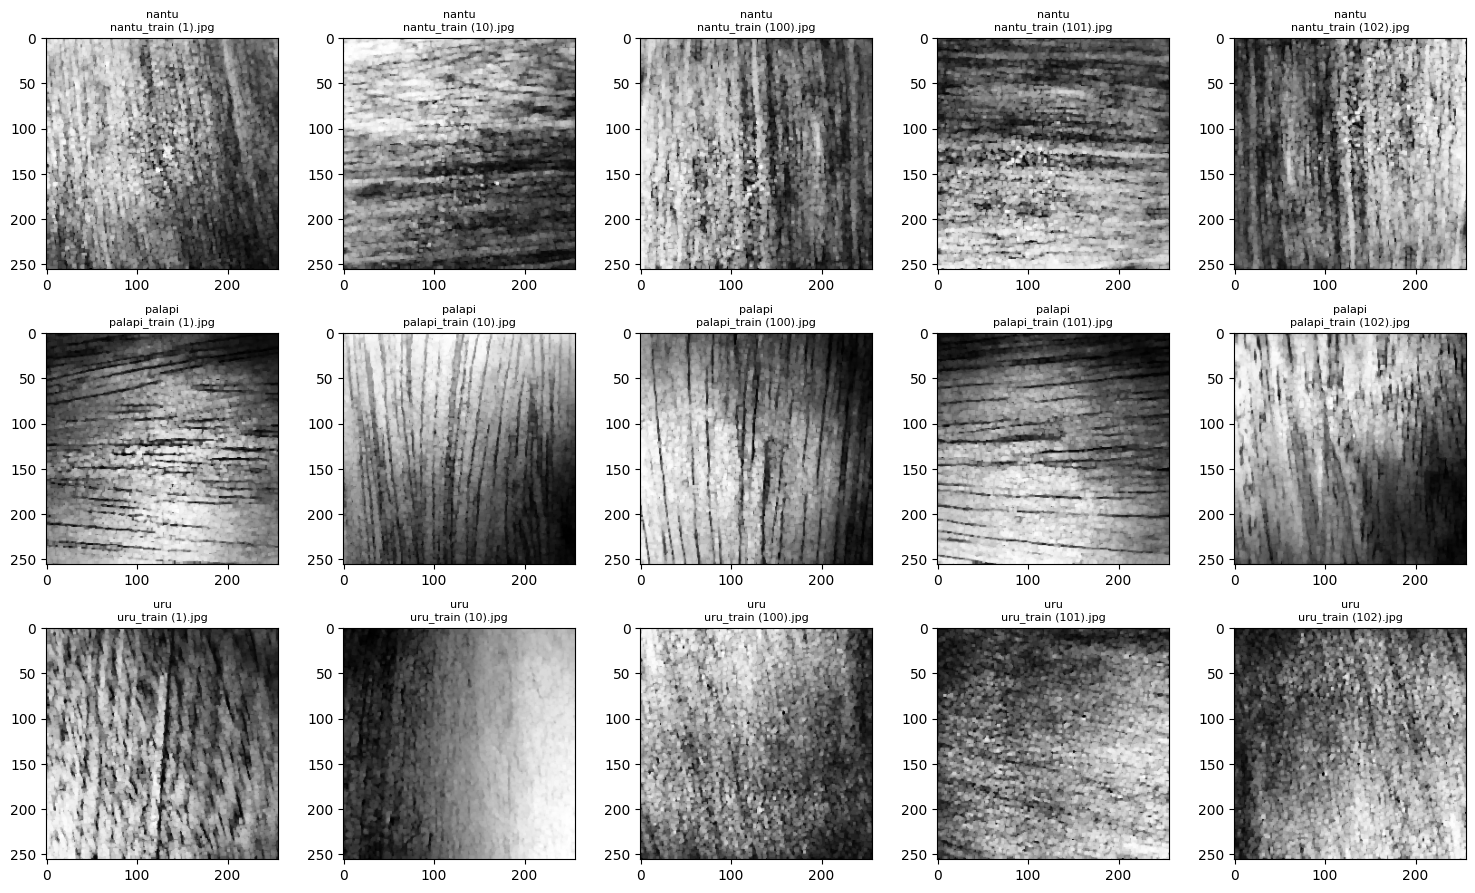

In [5]:
# Visualisasi 5 citra pertama dari setiap label
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 3 * len(unique_labels)))
for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 index pertama dari label tsb
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i * 5 + j + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.title(f"{label}\n{file_name[idx]}", fontsize=8)

plt.tight_layout()
plt.show()

# Ekstraksi GLCM

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [7]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [8]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [9]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [10]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [11]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan_4.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan_4.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,nantu_train (1).jpg,nantu,439.078018,567.352111,269.439185,602.110573,0.499461,0.318769,0.534611,0.313481,...,0.006169,0.002520,0.073872,0.050919,0.078541,0.050197,0.920262,0.896853,0.951058,0.890531
1,nantu_train (10).jpg,nantu,186.433793,560.833818,451.318551,537.344391,0.559164,0.332043,0.500723,0.336478,...,0.007731,0.004322,0.097700,0.064971,0.087925,0.065743,0.975464,0.926070,0.940550,0.929167
2,nantu_train (100).jpg,nantu,577.680392,734.679923,299.812240,736.489504,0.498382,0.321911,0.548195,0.319320,...,0.008492,0.003511,0.083840,0.059616,0.092152,0.059253,0.904926,0.878997,0.950758,0.878703
3,nantu_train (101).jpg,nantu,304.580101,750.967659,589.916743,749.384744,0.548309,0.318619,0.493773,0.317654,...,0.006927,0.003486,0.092214,0.059180,0.083227,0.059043,0.949771,0.875864,0.902554,0.876129
4,nantu_train (102).jpg,nantu,592.001608,751.448212,304.106939,751.317586,0.494438,0.318976,0.547768,0.316120,...,0.008489,0.003466,0.083343,0.059244,0.092134,0.058870,0.902252,0.875838,0.949871,0.875863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,uru_train (95).jpg,uru,69.888971,188.914371,158.737914,202.304375,0.549878,0.338292,0.513381,0.335345,...,0.002876,0.001394,0.057311,0.037721,0.053633,0.037334,0.992591,0.979904,0.983136,0.978479
1265,uru_train (96).jpg,uru,159.822656,189.794756,69.789231,202.954787,0.513873,0.337600,0.549809,0.336389,...,0.003299,0.001411,0.053830,0.037749,0.057434,0.037569,0.983053,0.979848,0.992615,0.978450
1266,uru_train (97).jpg,uru,114.206327,142.504975,50.859988,141.261869,0.517375,0.339812,0.554693,0.339765,...,0.002736,0.001163,0.049546,0.034113,0.052305,0.034109,0.988832,0.986046,0.995030,0.986167
1267,uru_train (98).jpg,uru,51.032353,145.605121,117.549617,144.754494,0.554462,0.339408,0.516848,0.340591,...,0.002439,0.001160,0.052229,0.034024,0.049391,0.034064,0.995009,0.985720,0.988488,0.985803


<Axes: >

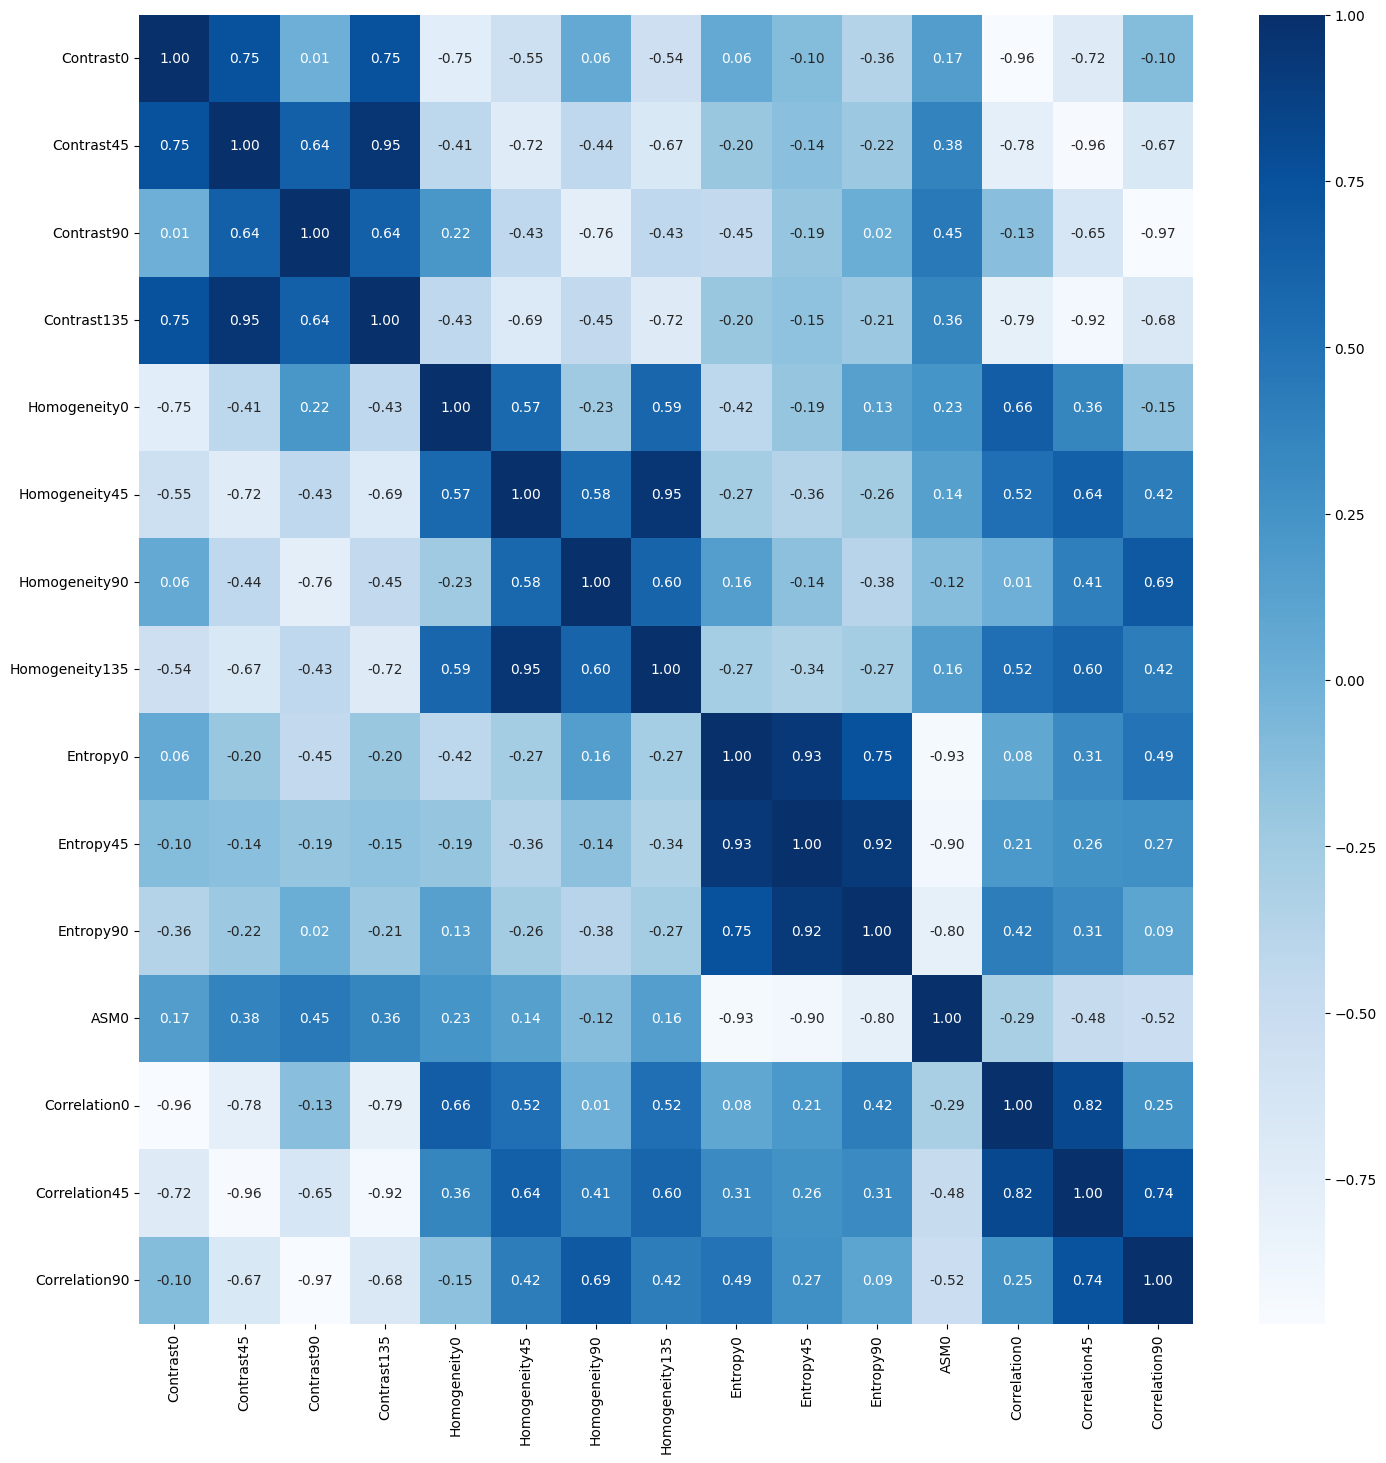

In [12]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

# Splitting data

In [13]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1015, 15)
(254, 15)


# Normalisasi Fitur

In [14]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

# Modelling

In [15]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

## Random Forest

In [16]:
# Train Random Forest
rf.fit(X_train, y_train)

# model training
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# model testing
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       nantu       0.98      1.00      0.99       331
      palapi       1.00      0.98      0.99       345
         uru       0.99      0.99      0.99       339

    accuracy                           0.99      1015
   macro avg       0.99      0.99      0.99      1015
weighted avg       0.99      0.99      0.99      1015

[[330   0   1]
 [  5 338   2]
 [  1   1 337]]
Accuracy: 0.9901477832512315

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.91      0.90      0.91        92
      palapi       0.86      0.90      0.88        78
         uru       0.93      0.90      0.92        84

    accuracy                           0.90       254
   macro avg       0.90      0.90      0.90       254
weighted avg       0.90      0.90      0.90       254

[[83  7  2]
 [ 4 70  4]
 [ 4  4 76]]
Accuracy: 0.9015748031496063


## SVM

In [17]:
# Train SVM
svm.fit(X_train, y_train)

# model training
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# model testing
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       nantu       0.78      0.85      0.82       331
      palapi       0.94      0.94      0.94       345
         uru       0.89      0.81      0.85       339

    accuracy                           0.87      1015
   macro avg       0.87      0.87      0.87      1015
weighted avg       0.87      0.87      0.87      1015

[[282  15  34]
 [ 19 325   1]
 [ 59   6 274]]
Accuracy: 0.8679802955665025

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.87      0.89      0.88        92
      palapi       0.97      0.94      0.95        78
         uru       0.88      0.89      0.89        84

    accuracy                           0.91       254
   macro avg       0.91      0.91      0.91       254
weighted avg       0.91      0.91      0.91       254

[[82  1  9]
 [ 4 73  1]
 [ 8  1 75]]
Accuracy: 0.905511811023622


## KNN

In [18]:
# Train KNN
knn.fit(X_train, y_train)

# model training
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# model testing
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       nantu       0.84      0.92      0.88       331
      palapi       0.95      0.96      0.95       345
         uru       0.94      0.85      0.89       339

    accuracy                           0.91      1015
   macro avg       0.91      0.91      0.91      1015
weighted avg       0.91      0.91      0.91      1015

[[304   8  19]
 [ 14 330   1]
 [ 42   9 288]]
Accuracy: 0.9083743842364532

------Testing Set------
              precision    recall  f1-score   support

       nantu       0.86      0.92      0.89        92
      palapi       0.97      0.94      0.95        78
         uru       0.94      0.89      0.91        84

    accuracy                           0.92       254
   macro avg       0.92      0.92      0.92       254
weighted avg       0.92      0.92      0.92       254

[[85  2  5]
 [ 5 73  0]
 [ 9  0 75]]
Accuracy: 0.9173228346456693


# Confusion Matrix

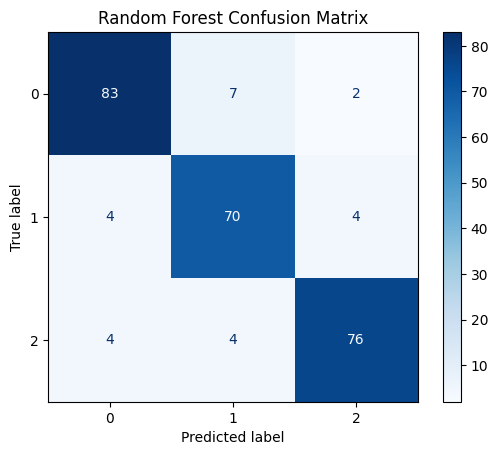

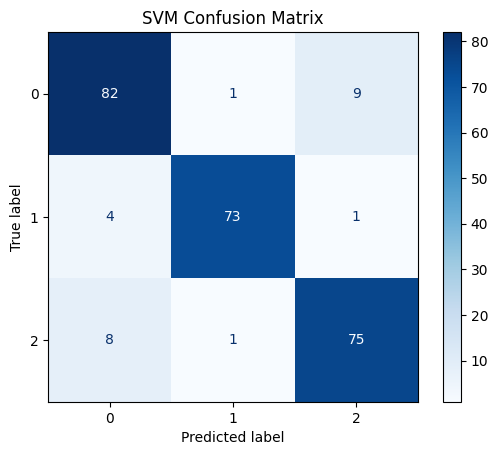

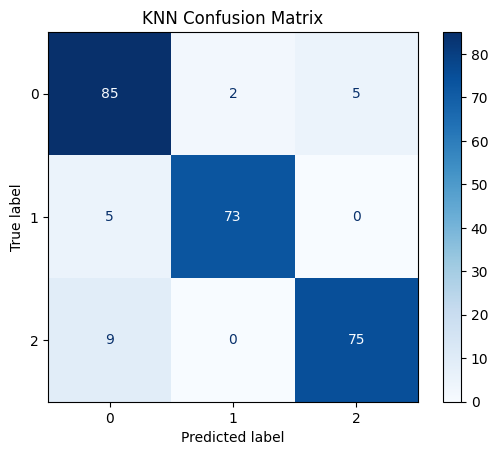

In [19]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# confusion matrix Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# confusion matrix SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# confusion matrix KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")